In [2]:
import torch
import torch.nn as nn
import torchvision

from torchvision import datasets, transforms, datasets

import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from datetime import datetime


In [3]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
print(device)

cuda


In [12]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [13]:
data_dir = 'data/muffin-dog'

# create datasets for training and validation data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transform[x]) 
                 for x in ['train', 'test']}

# get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# get class names from datasets
class_names = image_datasets['train'].classes
print(class_names)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               shuffle=True, num_workers=0)
                for x in ['train', 'test']}

['chihuahua', 'muffin']


In [5]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def imshow(inp, title=None):
    
    # use transpose to get the images into the correct shape

    inp = inp.numpy().transpose((1, 2, 0))

    # use default mean and std from ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # visualize inp
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

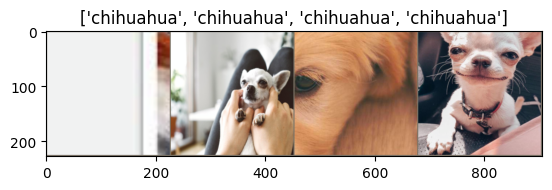

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    since = time.time()

    # Placeholders for best model weights and best accuracy
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc)) 
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


In [27]:
# Load a pretrained ResNet18 model
model_ft = torchvision.models.resnet18(pretrained=True)

# Replace the final fully connected layer to match our number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
best_model= train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.3874 Acc: 0.8534
test Loss: 0.1422 Acc: 0.9426

Epoch 1/7
----------
train Loss: 0.2743 Acc: 0.9028
test Loss: 0.0388 Acc: 0.9882

Epoch 2/7
----------
train Loss: 0.2061 Acc: 0.9203
test Loss: 0.0231 Acc: 0.9932

Epoch 3/7
----------
train Loss: 0.1285 Acc: 0.9499
test Loss: 0.0193 Acc: 0.9932

Epoch 4/7
----------
train Loss: 0.1156 Acc: 0.9569
test Loss: 0.0255 Acc: 0.9916

Epoch 5/7
----------
train Loss: 0.0984 Acc: 0.9632
test Loss: 0.0204 Acc: 0.9958

Epoch 6/7
----------
train Loss: 0.0988 Acc: 0.9658
test Loss: 0.0186 Acc: 0.9941

Epoch 7/7
----------
train Loss: 0.0571 Acc: 0.9789
test Loss: 0.0154 Acc: 0.9941

Training complete in 5m 57s
Best test Acc: 0.995777


In [28]:
# Save the best model weights
torch.save(best_model.state_dict(), 'muffin_dog_model_weights')
torch.save(best_model, 'muffin_dog_model')

In [30]:
# Load the best model weights
model_ft_state_dict = torch.load('muffin_dog_model_weights')

model_ft = torchvision.models.resnet18(pretrained=True)


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # Ensure output matches saved model for 2 classes
model_ft.load_state_dict(model_ft_state_dict)
model_ft = model_ft.to(device)

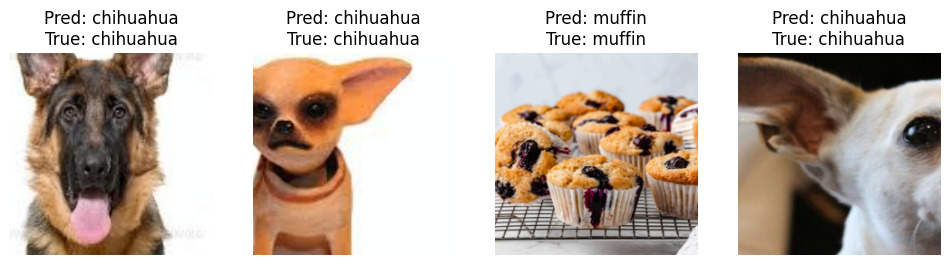

In [23]:
# Get a batch of images from the train dataloader
inputs, labels = next(iter(dataloaders['train']))

# Move inputs to the correct device
inputs = inputs.to(device)

# Set model to evaluation mode
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

# Move inputs to cpu for visualization
inputs_cpu = inputs.cpu()


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
                    
# Show images with predicted and true labels
plt.figure(figsize=(12, 6))
for i in range(inputs_cpu.size(0)):
    ax = plt.subplot(1, inputs_cpu.size(0), i + 1)
    inp = inputs_cpu[i].numpy().transpose((1, 2, 0))

 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()

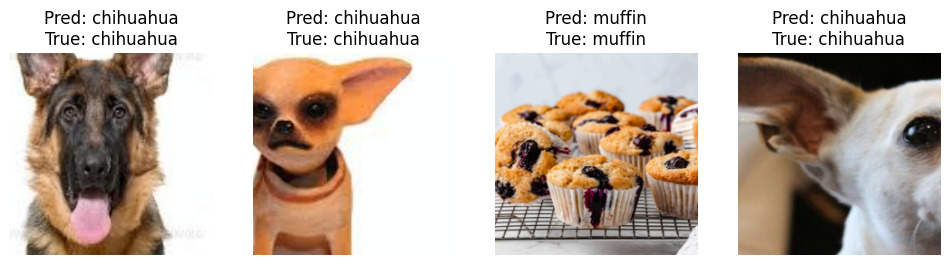

In [32]:
model_ft = torch.load('muffin_dog_model', weights_only=False)
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

# Move inputs to cpu for visualization
inputs_cpu = inputs.cpu()


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
                    
# Show images with predicted and true labels
plt.figure(figsize=(12, 6))
for i in range(inputs_cpu.size(0)):
    ax = plt.subplot(1, inputs_cpu.size(0), i + 1)
    inp = inputs_cpu[i].numpy().transpose((1, 2, 0))

 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()